## HW3: Problem 3

The code here is used for problem 3 of HW3.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm

In [22]:
# Load the data
df = pd.read_csv('../data/Data_Lecture_3.csv', index_col=0, parse_dates=True)

In [23]:
df = df.rolling(11).sum().shift()
# Drop NaN values (first 11 months)
df = df.dropna()
# Rank in ascending order, for each time step
ranked_df = df.rank(axis=1)
ranked_df.head()

,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XYL,YUM,ZBH,ZION,MKT,SMB,HML,RF,CPI,IndProd
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,216.0,423.0,293.0,63.0,407.0,150.0,124.0,349.0,116.0,343.0,...,201.0,126.0,277.0,267.0,218.0,59.0,42.0,32.0,34.0,36.0
2014-01-31,238.0,430.0,375.0,214.0,401.0,119.0,138.0,405.0,165.0,390.0,...,210.0,147.0,212.0,240.0,234.0,73.0,47.0,46.0,53.0,54.0
2014-02-28,368.0,452.0,399.0,179.0,379.0,129.0,128.0,396.0,121.0,257.0,...,236.0,84.0,267.0,210.0,237.0,98.0,41.0,48.0,60.0,68.0
2014-03-31,337.0,448.0,396.0,218.0,309.0,162.0,142.0,403.0,144.0,227.0,...,372.0,85.0,251.0,250.0,237.0,97.0,43.0,49.0,61.0,68.0
2014-04-30,334.0,450.0,393.0,238.0,226.0,104.0,55.0,379.0,239.0,289.0,...,314.0,151.0,244.0,257.0,223.0,110.0,81.0,62.0,73.0,82.0


In [24]:
# Find the 100 companies with best and worst returns
worst_mask = ranked_df<=100
best_mask = (355<ranked_df) & (ranked_df<=455)
worst_avg = df.where(worst_mask).mean(axis=1)
best_avg = df.where(best_mask).mean(axis=1)
worst_avg.head(), best_avg.head()

(Date
 2013-12-31    1.239963
 2014-01-31   -1.529257
 2014-02-28   -2.585661
 2014-03-31   -2.791504
 2014-04-30   -4.220694
 dtype: float64, Date
 2013-12-31    55.403097
 2014-01-31    50.718519
 2014-02-28    49.152139
 2014-03-31    51.018520
 2014-04-30    47.913327
 dtype: float64)

In [25]:
# Get the difference between best and worst averages
factor = best_avg - worst_avg
factor.head()

Date
2013-12-31    54.163134
2014-01-31    52.247775
2014-02-28    51.737800
2014-03-31    53.810023
2014-04-30    52.134021
dtype: float64

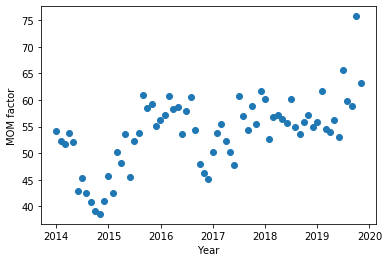

In [108]:
# Plot the momentum factor
fig, ax = plt.subplots(1,1)
ax.plot(factor, 'o')
ax.set_xlabel('Year')
ax.set_ylabel('MOM factor')
fig.savefig('../output/mom_factor.pdf')

### Regression

Here, we run a regression using MKT, SMB, HML factors together with the newly constructed momentum (MOM) factor to estimate the $\beta$-factors in the following relation:

$R_{p,t}^e = \alpha + \beta_M R_{M,t}^e + \beta_{SMB} R_{SMB,t}^e + \beta_{HML} R_{HML,t}^e + \beta_{MOM} R_{MOM,t}^e + \epsilon_t$

For the excess stock returns, we'll use Apple excess returns.

In [88]:
# Get Apple excess returns
aapl = (df['AAPL'] - df['RF']).rename('AAPL_E')
comb_df = pd.concat([
    aapl,
    df['MKT'],
    df['SMB'],
    df['HML'],
    factor.rename('MOM')
], axis=1)
comb_df.head()

,AAPL_E,MKT,SMB,HML,MOM
Date,,,,,
2013-12-31,6.865672,28.05,6.03,1.71,54.163134
2014-01-31,23.311377,25.29,5.14,0.45,52.247775
2014-02-28,14.494308,20.68,6.45,-1.67,51.737800
2014-03-31,19.797606,21.30,5.99,-1.78,53.810023
2014-04-30,21.746144,20.18,6.52,2.67,52.134021


In [89]:
# Run regression
model = sm.ols('AAPL_E ~ MKT + SMB + HML + MOM', data=comb_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AAPL_E   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     21.73
Date:                Mon, 10 Feb 2020   Prob (F-statistic):           1.79e-11
Time:                        13:45:14   Log-Likelihood:                -286.27
No. Observations:                  71   AIC:                             582.5
Df Residuals:                      66   BIC:                             593.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.9497     17.088      2.396      0.019       6.832      75.067
MKT            1.8038      0.258      6.989      0.000       1.288       2.319
SMB           -0.0784      0.335     -0.234      0.816      -0.747       0.591
HML           -0.8120      0.275     -2.952      0.004      -1.361      -0.263
MOM           -0.8444      0.297     -2.847      0.006      -1.436      -0.252
==============================================================================
Omnibus:                        0.080   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.108
Skew:                          -0.070   Prob(JB):                        0.947
Kurtosis:                       2.870   Cond. No.                         564.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

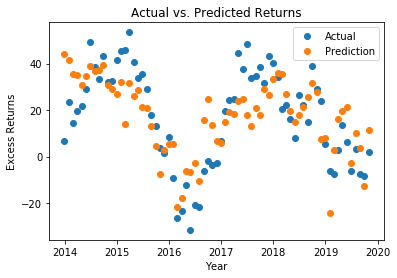

In [106]:
# Get the parameters, plot the results
param_set = model.params.values

def prediction(param_set, df):
    return param_set[0] + param_set[1]*df['MKT'] + param_set[2]*df['SMB'] + param_set[3]*df['HML'] + param_set[4]*df['MOM']

pred = prediction(param_set, df=comb_df)
actual = comb_df['AAPL_E']

err = (pred-actual)*100/actual

fig, ax = plt.subplots(1,1)
ax.plot(actual,'o',label='Actual')
ax.plot(pred,'o', label='Prediction')
ax.set_xlabel('Year')
ax.set_ylabel('Excess Returns')
ax.set_title('Actual vs. Predicted Returns')
ax.legend()
fig.savefig('../output/pred_hw3q3.pdf')


In [109]:
param_set

array([40.94965675,  1.80380612, -0.07836873, -0.81202584, -0.84441395])